# Initial analysis of fit models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import string
import warnings
from pathlib import Path
from time import time
from typing import Dict, List, Optional, Tuple, Union

import arviz as az
import janitor
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

In [3]:
import src.modeling.pymc3_analysis as pmanal
from src.command_line_interfaces import sampling_pymc3_models_cli as sampling
from src.command_line_interfaces.cli_helpers import ModelOption
from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.io import data_io
from src.io.cache_io import default_cache_dir
from src.modeling import pymc3_sampling_api as pmapi
from src.models.crc_model import CrcModel
from src.plot.color_pal import ModelColors, SeabornColor

In [4]:
notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_bw())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 1111
np.random.seed(RANDOM_SEED)

HDI_PROB = 0.89

## Data

In [5]:
dm_guide_efficacy = pd.read_csv(
    data_io.data_path(data_io.DataFile.achilles_guide_efficacy)
)
dm_guide_efficacy.head()

,sgRNA,offset,efficacy
0,AAAAAAATCCAGCAATGCAG,-0.021827,0.999956
1,AAAAAACCCGTAGATAGCCT,-0.943473,0.028545
2,AAAAAAGAAGAAAAAACCAG,0.411906,0.999845
3,AAAAAAGCTCAAGAAGGAGG,-0.245704,0.999886
4,AAAAAAGGCTGTAAAAGCGT,-0.081956,0.661372


In [6]:
dm_essentials = pd.read_csv(data_io.data_path(data_io.DataFile.achilles_essentials))

essential_genes = dm_essentials.gene[dm_essentials.essential]
nonessential_genes = dm_essentials.gene[~dm_essentials.essential]

print(f"    num. essential genes: {len(essential_genes)}")
print(f"num. non-essential genes: {len(nonessential_genes)}")

dm_essentials.head()

    num. essential genes: 1246
num. non-essential genes: 758


,gene,essential
0,AAMP,True
1,AARS,True
2,AASDHPPT,True
3,ABCB7,True
4,ABCE1,True


## Load models

In [7]:
fit_models: Dict[str, CrcModel] = {}

model_info = (
    (ModelOption.crc_model_one, "CRC-m1"),
    (ModelOption.crc_ceres_mimic, "CERES-copynumber-sgrnaint"),
)

for m, n in model_info:
    fit_models[n] = sampling.sample_speclet_model(m, n, debug=False)

(INFO) Cache directory: /n/data2/dfci/cancerbio/haigis/Cook/speclet/models/model_cache/pymc3_model_cache/CRC-m1
(INFO) Sampling 'crc_model_one' with custom name 'CRC-m1'
(INFO) Running model build method.
(INFO) Running ADVI fitting method.
/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
(INFO) finished; execution time: 1.37 minutes
(INFO) Cach

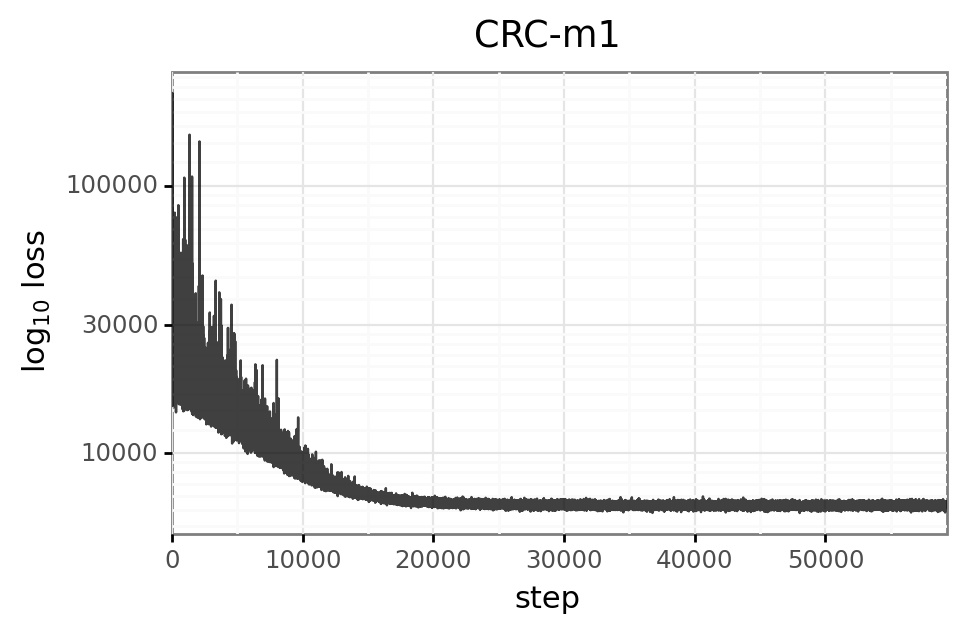

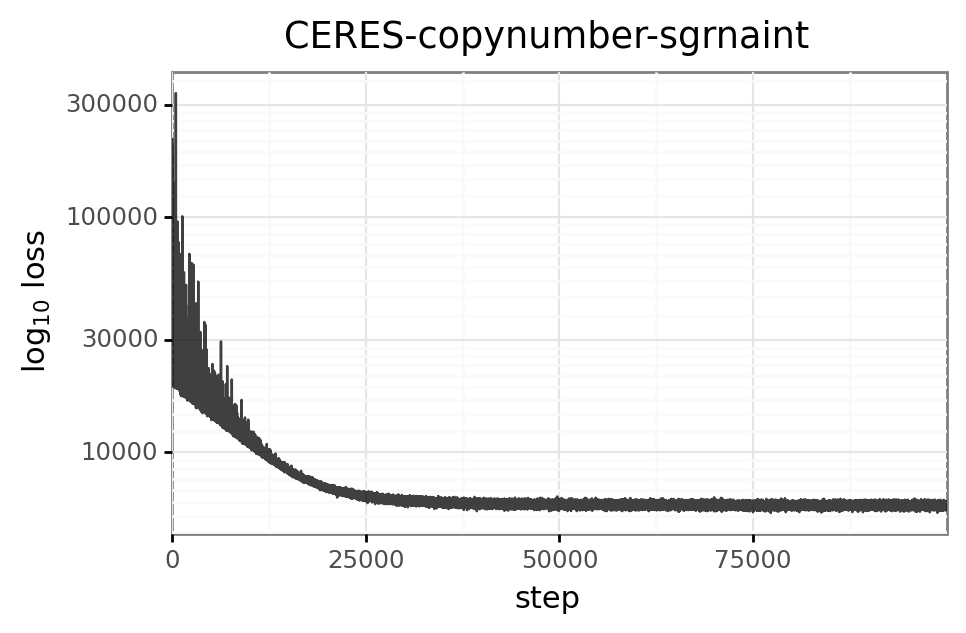

In [8]:
for name, model in fit_models.items():
    p = pmanal.plot_vi_hist(model.advi_results.approximation)
    p = (
        p
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_log10()
        + gg.theme(figure_size=(5, 3))
        + gg.labs(y=r"$\log_{10}$ loss", title=name)
    )
    print(p)

In [9]:
ceres_mimic = fit_models["CERES-copynumber-sgrnaint"]
ceres_mimic.data["depmap_id"].cat.categories

az_ceres_mimic = pmapi.convert_samples_to_arviz(
    ceres_mimic.model, ceres_mimic.advi_results
)

In [10]:
mimic_gene_effect = (
    az.summary(az_ceres_mimic, var_names="d", kind="stats", hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "param_idx"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="param_idx",
        idx1=ceres_mimic.data["hugo_symbol"].cat.categories,
        idx2=ceres_mimic.data["depmap_id"].cat.categories,
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)

mimic_gene_effect.head()

,param_idx,mean,sd,hdi_5.5%,hdi_94.5%,hugo_symbol,depmap_id
0,"d[0,0]",0.122,0.362,-0.446,0.717,A2ML1,ACH-000007
1,"d[0,1]",0.096,0.357,-0.430,0.696,A2ML1,ACH-000009
2,"d[0,2]",0.020,0.370,-0.551,0.611,A2ML1,ACH-000202
3,"d[0,3]",0.141,0.383,-0.478,0.723,A2ML1,ACH-000249
4,"d[0,4]",0.251,0.386,-0.353,0.867,A2ML1,ACH-000253


In [11]:
dm_gene_effect_path = data_io.modeling_data_dir() / "achilles_gene_effect.csv"
dm_gene_effect = pd.read_csv(dm_gene_effect_path)

for col in ["hugo_symbol", "depmap_id"]:
    idx = dm_gene_effect[col].isin(ceres_mimic.data[col].cat.categories)
    dm_gene_effect = dm_gene_effect[idx]

dm_gene_effect = dm_gene_effect.reset_index(drop=True)
dm_gene_effect.head()

,depmap_id,hugo_symbol,gene_effect,gene_effect_unscaled
0,ACH-000007,A2ML1,0.157945,0.405450
1,ACH-000009,A2ML1,0.054225,0.373386
2,ACH-000202,A2ML1,0.028024,0.291517
3,ACH-000249,A2ML1,0.309057,0.536752
4,ACH-000253,A2ML1,0.236280,0.794892


In [12]:
merged_gene_effect = pd.merge(
    dm_gene_effect,
    mimic_gene_effect[["hugo_symbol", "depmap_id", "mean", "hdi_5.5%", "hdi_94.5%"]],
    how="inner",
    on=["depmap_id", "hugo_symbol"],
)

In [13]:
merged_gene_effect.head()

,depmap_id,hugo_symbol,gene_effect,gene_effect_unscaled,mean,hdi_5.5%,hdi_94.5%
0,ACH-000007,A2ML1,0.157945,0.405450,0.122,-0.446,0.717
1,ACH-000009,A2ML1,0.054225,0.373386,0.096,-0.430,0.696
2,ACH-000202,A2ML1,0.028024,0.291517,0.020,-0.551,0.611
3,ACH-000249,A2ML1,0.309057,0.536752,0.141,-0.478,0.723
4,ACH-000253,A2ML1,0.236280,0.794892,0.251,-0.353,0.867


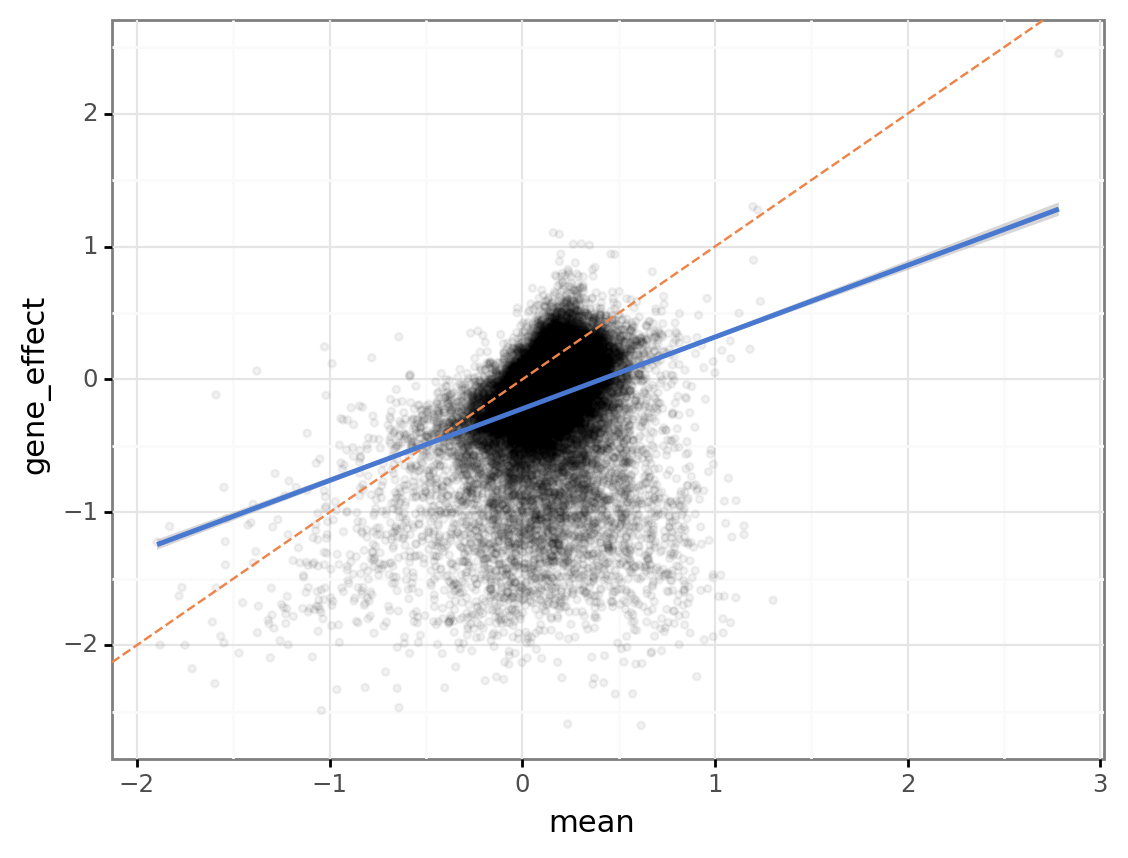

<ggplot: (8727116748831)>

In [14]:
(
    gg.ggplot(merged_gene_effect, gg.aes(x="mean", y="gene_effect"))
    + gg.geom_point(size=1, alpha=0.05)
    + gg.geom_abline(intercept=0, slope=1, color=SeabornColor.orange, linetype="--")
    + gg.geom_smooth(method="lm", color=SeabornColor.blue)
)

In [15]:
import scipy.stats

gene_effect_corr = scipy.stats.pearsonr(
    merged_gene_effect["gene_effect"], merged_gene_effect["mean"]
)
print(f"correlation: {gene_effect_corr[0]:.3f}")
print(f"    p-value: {gene_effect_corr[1]:.2e}")

correlation: 0.285
    p-value: 0.00e+00


In [16]:
from typing import List, Union


def extract_param_name(params: Union[np.ndarray, pd.Series, List]) -> List[str]:
    return [re.split(r"\[", p)[0] for p in params]


def extract_param_idx(params: Union[np.ndarray, pd.Series, List]) -> List[int]:
    return [int(re.findall(r"\d+", p)[0]) for p in params]

In [17]:
guide_efficacy_params = (
    az.summary(az_ceres_mimic, var_names=["q", "o"], kind="stats", hdi_prob=HDI_PROB)
    .drop(columns=["sd"])
    .reset_index(drop=False)
    .rename(columns={"index": "model_param"})
    .assign(
        param_name=lambda d: extract_param_name(d.model_param),
        sgrna_idx=lambda d: extract_param_idx(d.model_param),
    )
    .pivot_wider(
        index="sgrna_idx",
        names_from="param_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
)

guide_efficacy_params.head()

,sgrna_idx,q_mean,o_mean,q_hdi_5.5%,o_hdi_5.5%,q_hdi_94.5%,o_hdi_94.5%
0,0,0.144,0.546,0.039,0.476,0.240,0.626
1,1,0.156,0.429,0.040,0.359,0.256,0.509
2,2,0.128,0.243,0.030,0.168,0.224,0.317
3,3,0.126,0.386,0.028,0.316,0.223,0.463
4,4,0.082,0.529,0.007,0.451,0.156,0.606


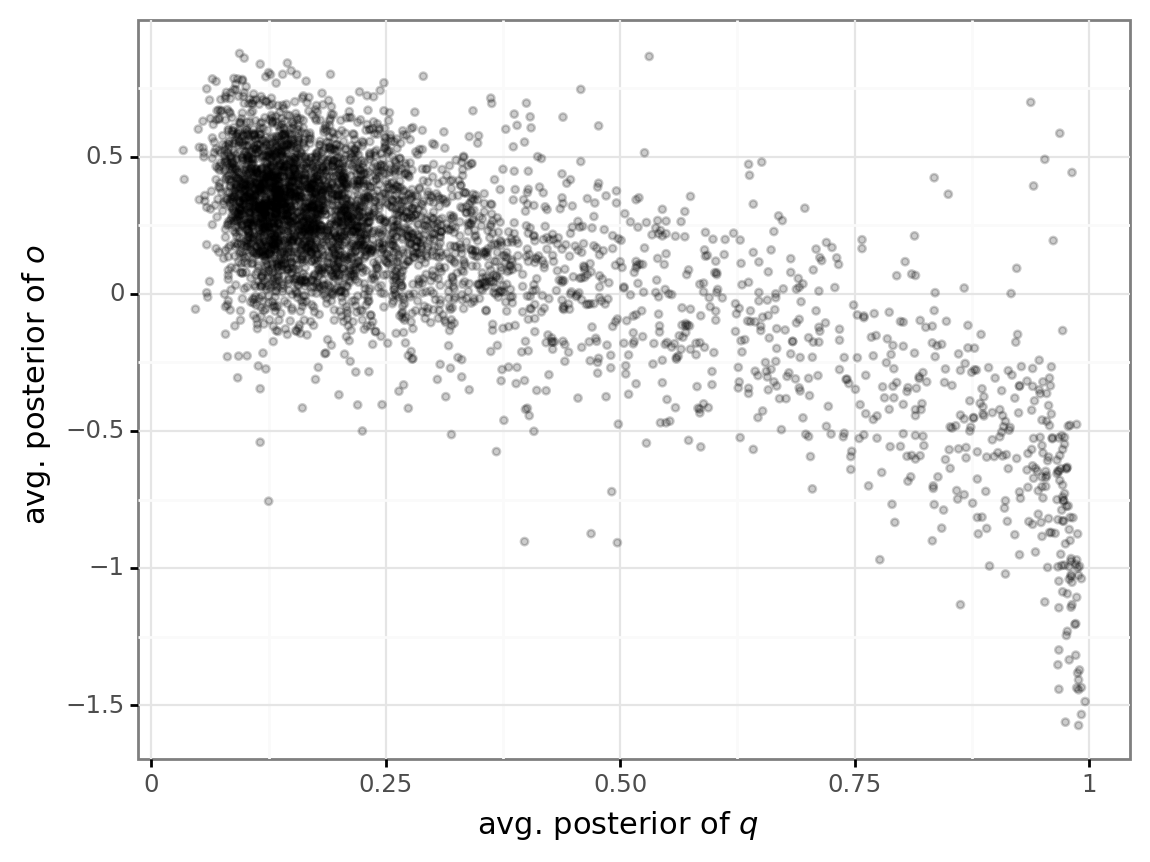

<ggplot: (8727116723800)>

In [18]:
(
    gg.ggplot(guide_efficacy_params, gg.aes(x="q_mean", y="o_mean"))
    + gg.geom_point(size=1, alpha=0.2)
    + gg.labs(x="avg. posterior of $q$", y="avg. posterior of $o$")
)

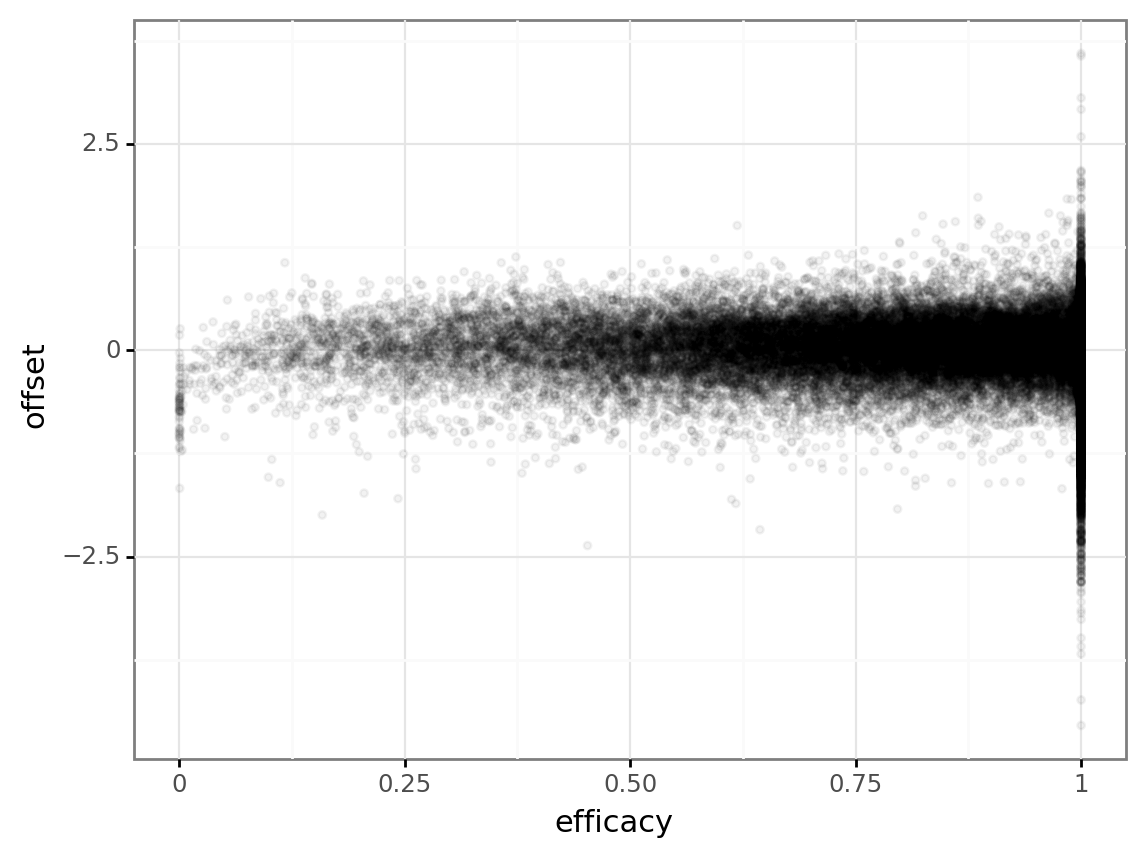

<ggplot: (8727112498713)>

In [19]:
(
    gg.ggplot(dm_guide_efficacy, gg.aes(x="efficacy", y="offset"))
    + gg.geom_point(size=1, alpha=0.05)
)

In [20]:
merged_gene_effect_long = (
    merged_gene_effect[["depmap_id", "hugo_symbol", "gene_effect_unscaled", "mean"]]
    .rename(columns={"gene_effect_unscaled": "CERES", "mean": "CERES-mimic"})
    .pivot_longer(
        column_names=["CERES", "CERES-mimic"], names_to="model", values_to="gene_effect"
    )
)

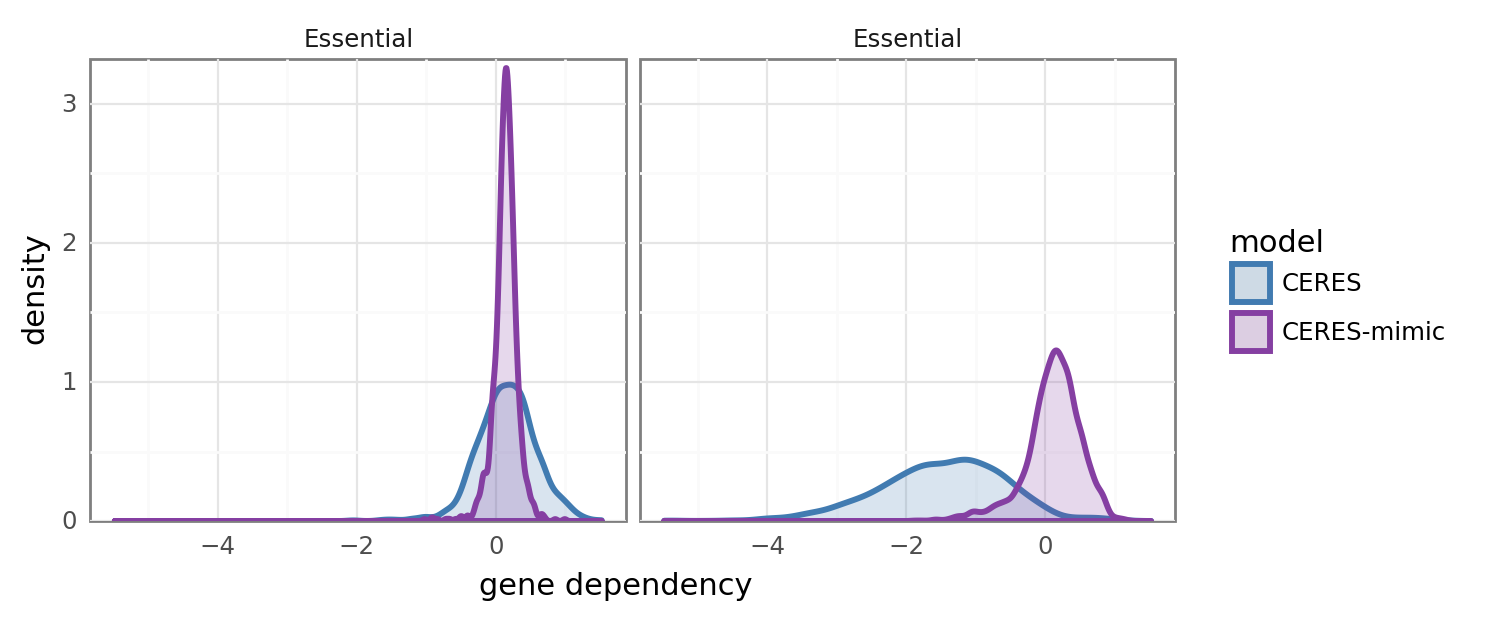

<ggplot: (8727112920643)>

In [21]:
pal = {"CERES": ModelColors.CERES, "CERES-mimic": ModelColors.CERES_mimic}

essential_labeller = lambda x: "Essential" if x else "Non-essential"


(
    gg.ggplot(
        merged_gene_effect_long.merge(
            dm_essentials, how="inner", left_on="hugo_symbol", right_on="gene"
        ),
        gg.aes(x="gene_effect", color="model", fill="model"),
    )
    + gg.facet_wrap("essential", nrow=1, labeller=essential_labeller)
    + gg.geom_density(alpha=0.2, size=1.2)
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.scale_color_manual(values=pal)
    + gg.scale_fill_manual(values=pal)
    + gg.theme(
        strip_background=gg.element_blank(),
        axis_ticks_major=gg.element_blank(),
        figure_size=(7, 3),
    )
    + gg.labs(
        x="gene dependency",
        y="density",
        color="model",
        fill="model",
    )
)

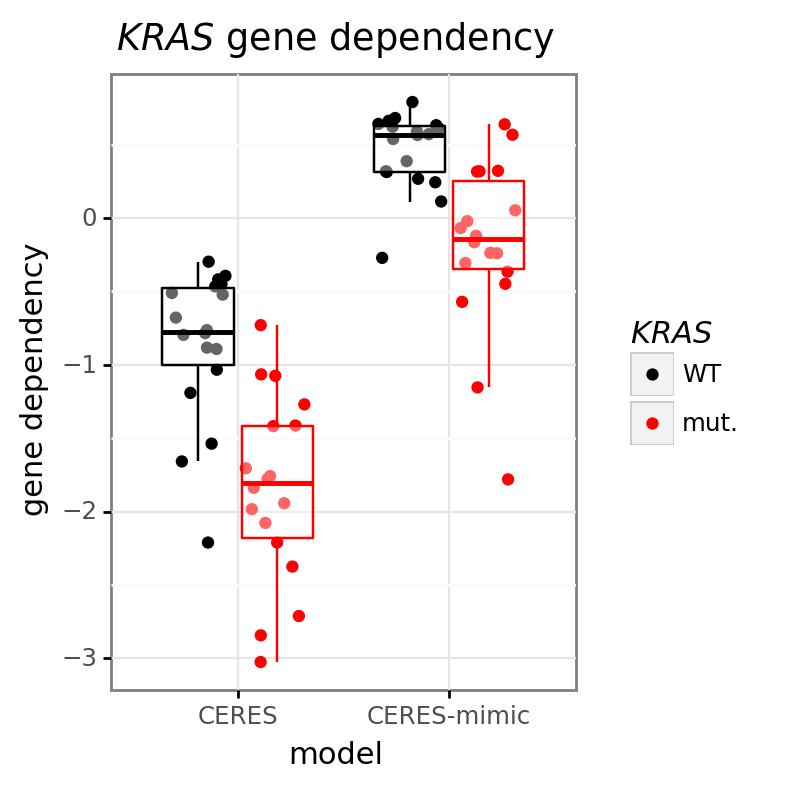

<ggplot: (8727116753972)>

In [22]:
def merge_with_kras_mut(df: pd.DataFrame, full_data: pd.DataFrame) -> pd.DataFrame:
    return (
        df.copy()
        .merge(
            full_data.copy()[["depmap_id", "kras_mutation"]].drop_duplicates(),
            on="depmap_id",
        )
        .reset_index(drop=True)
        .assign(KRAS=lambda d: d.kras_mutation != "WT")
    )


kras_dep_long = merge_with_kras_mut(
    merged_gene_effect_long.query("hugo_symbol == 'KRAS'"), ceres_mimic.data
)

(
    gg.ggplot(
        kras_dep_long,
        gg.aes(x="model", y="gene_effect", color="KRAS"),
    )
    + gg.geom_point(position=gg.position_jitterdodge(jitter_height=0, jitter_width=0.3))
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4, fill="white", show_legend=False)
    + gg.scale_color_manual(values=("black", "red"), labels=("WT", "mut."))
    + gg.theme(figure_size=(3, 4))
    + gg.labs(
        x="model", y="gene dependency", title="$KRAS$ gene dependency", color="$KRAS$"
    )
)

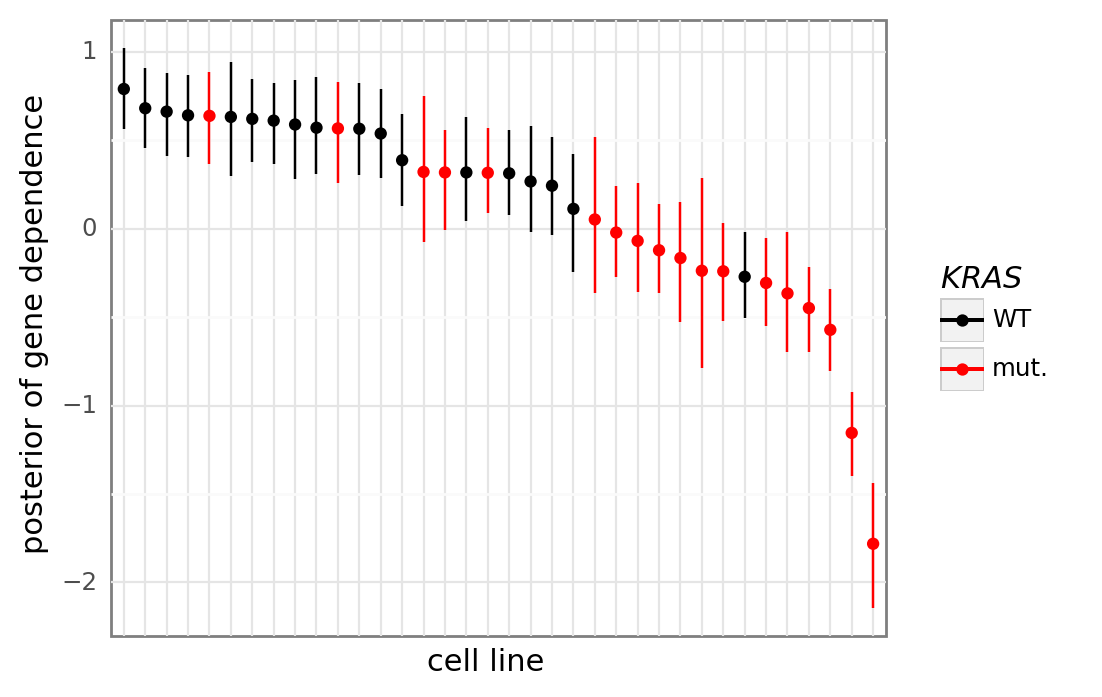

<ggplot: (8727872050195)>

In [23]:
kras_dep = (
    merge_with_kras_mut(
        merged_gene_effect.query("hugo_symbol == 'KRAS'"), ceres_mimic.data
    )
    .sort_values("mean", ascending=False)
    .pipe(dphelp.make_cat, col="depmap_id")
)

(
    gg.ggplot(kras_dep, gg.aes(x="depmap_id", y="mean", color="KRAS"))
    + gg.geom_point()
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.scale_color_manual(values=("black", "red"), labels=("WT", "mut."))
    + gg.theme(
        axis_text_x=gg.element_blank(),
        axis_ticks_major=gg.element_blank(),
        figure_size=(5, 4),
    )
    + gg.labs(x="cell line", y="posterior of gene dependence", color="$KRAS$")
)

In [24]:
kras_idx = np.where(ceres_mimic.data.hugo_symbol.cat.categories.values == "KRAS")[0][0]
az.summary(az_ceres_mimic, var_names=["h"], kind="stats", hdi_prob=HDI_PROB).iloc[
    kras_idx, :
]

mean        -0.240
sd           0.022
hdi_5.5%    -0.274
hdi_94.5%   -0.205
Name: h[452], dtype: float64

In [25]:
depmap_id_map = (
    ceres_mimic.data.copy()[["depmap_id"]].drop_duplicates().reset_index(drop=True)
)
depmap_id_map["idx"] = dphelp.get_indices(depmap_id_map, col="depmap_id")

In [26]:
def filter_for_tp53(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.copy()
        .filter_column_isin("depmap_id", iterable=depmap_id_map.depmap_id.values)
        .query("hugo_symbol == 'TP53'")
        .reset_index(drop=True)
    )


ccle_mutation_df = pd.read_csv(
    data_io.data_path(data_io.DataFile.ccle_mutations), nrows=None, low_memory=False
).pipe(filter_for_tp53)

ccle_mutation_df.head()

,depmap_id,hugo_symbol,chromosome,start_position,end_position,variant_classification,variant_type,reference_allele,tumor_seq_allele1,cdna_change,codon_change,protein_change,isdeleterious,istcgahotspot,iscosmichotspot
0,ACH-001460,TP53,17,7574003,7574003,Nonsense_Mutation,SNP,G,A,c.1024C>T,c.(1024-1026)Cga>Tga,p.R342*,True,True,True
1,ACH-000651,TP53,17,7576921,7576921,Missense_Mutation,SNP,G,A,c.925C>T,c.(925-927)Ccc>Tcc,p.P309S,False,False,True
2,ACH-000963,TP53,17,7577105,7577105,Missense_Mutation,SNP,G,T,c.833C>A,c.(832-834)cCt>cAt,p.P278H,False,True,True
3,ACH-000683,TP53,17,7577120,7577120,Missense_Mutation,SNP,C,A,c.818G>T,c.(817-819)cGt>cTt,p.R273L,False,True,True
4,ACH-000552,TP53,17,7577120,7577120,Missense_Mutation,SNP,C,T,c.818G>A,c.(817-819)cGt>cAt,p.R273H,False,True,True


In [27]:
ccle_copynumber_df = (
    pd.read_csv(
        data_io.data_path(data_io.DataFile.ccle_copynumber),
        nrows=None,
        low_memory=False,
    )
    .pipe(filter_for_tp53)
    .assign(
        TP53_lost=lambda d: d.copy_number < 0.5,
        TP53_cn=lambda d: np.round(d.copy_number),
    )
)

ccle_copynumber_df.head()

,depmap_id,hugo_symbol,log2_cn_p1,copy_number,TP53_lost,TP53_cn
0,ACH-000007,TP53,0.975354,1.652105,False,2.0
1,ACH-000009,TP53,0.624936,0.868127,False,1.0
2,ACH-000202,TP53,0.895190,1.447801,False,1.0
3,ACH-000249,TP53,0.604368,0.830096,False,1.0
4,ACH-000253,TP53,0.996197,1.707964,False,2.0


In [28]:
copynumber_effect = (
    az.summary(az_ceres_mimic, var_names=["β"], kind="stats", hdi_prob=HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "model_param"})
    .assign(
        param_name=lambda d: extract_param_name(d.model_param),
        depmap_idx=lambda d: extract_param_idx(d.model_param),
    )
    .merge(depmap_id_map, left_on="depmap_idx", right_on="idx")
    .assign(depmap_id=lambda d: d.depmap_id.values)
    .merge(
        ccle_mutation_df[["depmap_id", "variant_classification"]],
        how="left",
        on="depmap_id",
    )
    .merge(ccle_copynumber_df[["depmap_id", "TP53_cn"]], how="left", on="depmap_id")
    .rename(columns={"variant_classification": "TP53"})
    .fillna({"TP53": "WT", "TP53_cn": 2})
)
copynumber_effect.head()

,model_param,mean,sd,hdi_5.5%,hdi_94.5%,param_name,depmap_idx,depmap_id,idx,TP53,TP53_cn
0,β[0],-0.182,0.015,-0.206,-0.159,β,0,ACH-000007,0,WT,2.0
1,β[1],-0.073,0.009,-0.088,-0.057,β,1,ACH-000009,1,Nonsense_Mutation,1.0
2,β[2],0.063,0.010,0.047,0.081,β,2,ACH-000202,2,Missense_Mutation,1.0
3,β[3],-0.115,0.020,-0.145,-0.082,β,3,ACH-000249,3,Missense_Mutation,1.0
4,β[4],-0.125,0.014,-0.146,-0.103,β,4,ACH-000253,4,WT,2.0


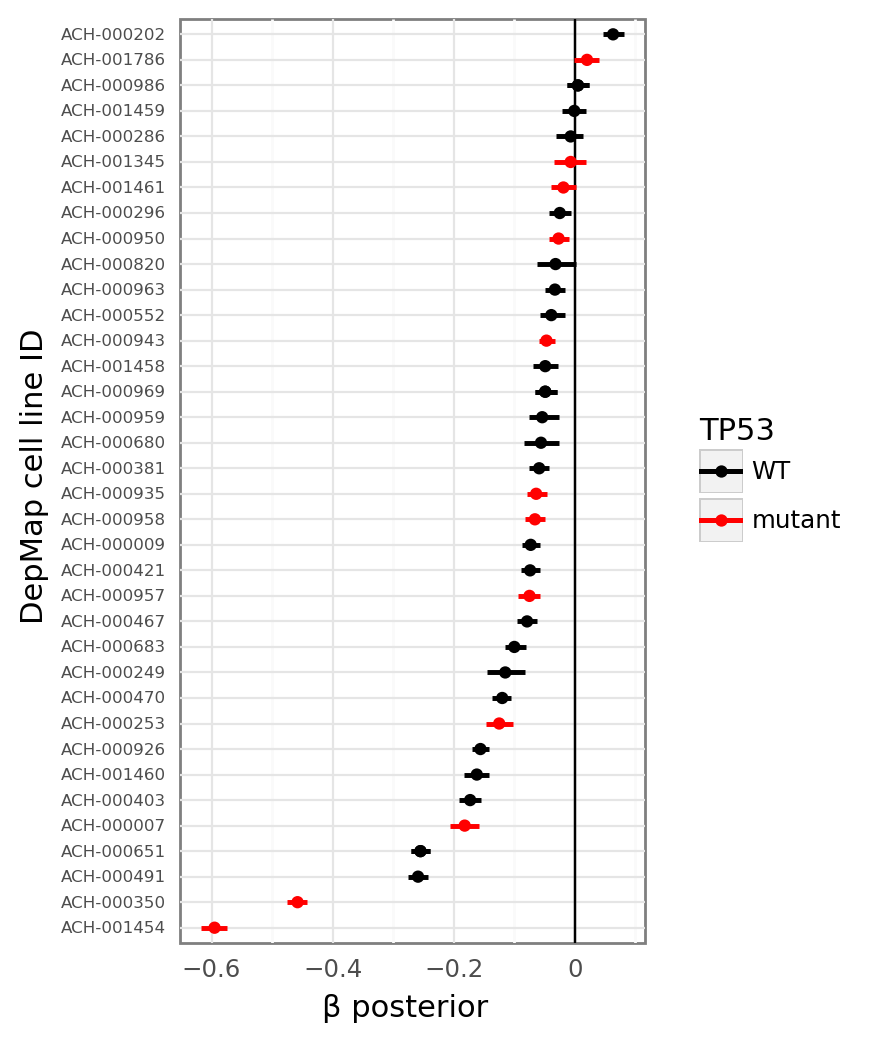

<ggplot: (8727113194984)>

In [29]:
copynumber_effect_plot = copynumber_effect.copy().sort_values("mean")
copynumber_effect_plot = dphelp.make_cat(
    copynumber_effect_plot, col="depmap_id"
).assign(TP53=lambda d: d.TP53 == "WT")

(
    gg.ggplot(copynumber_effect_plot, gg.aes(x="depmap_id", y="mean", color="TP53"))
    + gg.geom_hline(yintercept=0)
    + gg.geom_point()
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"), size=1)
    + gg.scale_color_manual(values=("black", "red"), labels=("WT", "mutant"))
    + gg.coord_flip()
    + gg.theme(
        axis_ticks_major=gg.element_blank(),
        axis_text_y=gg.element_text(size=6),
        figure_size=(3, 6),
    )
    + gg.labs(x="DepMap cell line ID", y="β posterior")
)

In [30]:
ceres_mimic_predictions = pmanal.summarize_posterior_predictions(
    ceres_mimic.advi_results.posterior_predictive.get("lfc"),
    hdi_prob=0.89,
    merge_with=ceres_mimic.data[
        ["depmap_id", "hugo_symbol", "lfc", "sgrna", "gene_cn", "rna_expr"]
    ],
    calc_error=True,
    observed_y="lfc",
)

ceres_mimic_predictions.head()

/home/jc604/.conda/envs/speclet/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,pred_mean,pred_hdi_low,pred_hdi_high,depmap_id,hugo_symbol,lfc,sgrna,gene_cn,rna_expr,error
0,0.297318,-0.364924,0.892873,ACH-000007,A2ML1,0.096711,ACAAACCTCTCTACACCCCA,1.652984,0.0,-0.200607
1,0.282719,-0.378074,0.941211,ACH-000007,A2ML1,0.804148,ACAAACCTCTCTACACCCCA,1.652984,0.0,0.521430
2,0.239842,-0.474657,0.867423,ACH-000009,A2ML1,-0.091043,ACAAACCTCTCTACACCCCA,2.601301,0.0,-0.330885
3,0.243564,-0.441624,0.947052,ACH-000009,A2ML1,0.339692,ACAAACCTCTCTACACCCCA,2.601301,0.0,0.096128
4,0.235671,-0.492772,0.777768,ACH-000009,A2ML1,0.211244,ACAAACCTCTCTACACCCCA,2.601301,0.0,-0.024427


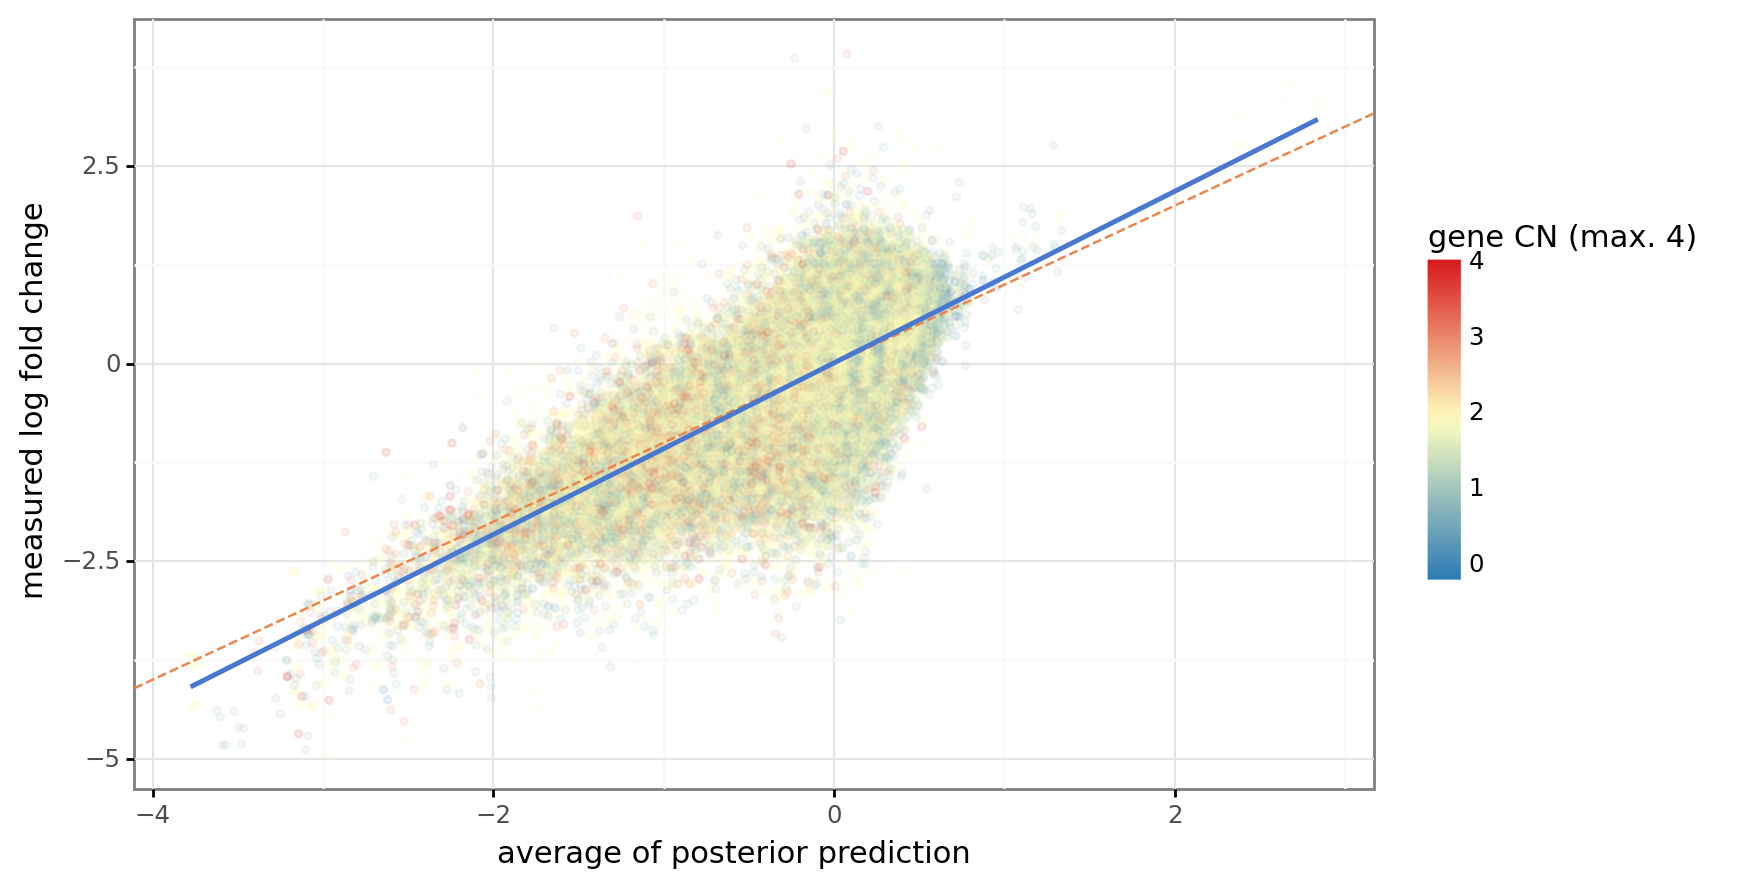

<ggplot: (8727116783077)>

In [31]:
(
    gg.ggplot(ceres_mimic_predictions, gg.aes(x="pred_mean", y="lfc"))
    + gg.geom_point(gg.aes(color="np.round(gene_cn)"), size=1, alpha=0.1)
    + gg.geom_abline(intercept=0, slope=1, color=SeabornColor.orange, linetype="--")
    + gg.geom_smooth(method="lm", color=SeabornColor.blue)
    + gg.scale_color_gradient2(
        limits=(0, 4),
        expand=(0, 0),
        midpoint=2,
        low="#2c7bb6",
        mid="#ffffbf",
        high="#d7191c",
        guide=gg.guide_colorbar(barwidth=8, ticks=False),
    )
    + gg.theme(figure_size=(8, 5))
    + gg.labs(
        x="average of posterior prediction",
        y="measured log fold change",
        color="gene CN (max. 4)",
    )
)

In [32]:
pred_corr = scipy.stats.pearsonr(
    ceres_mimic_predictions.pred_mean, ceres_mimic_predictions.lfc
)
print(f"correlation: {pred_corr[0]:.3f}")

correlation: 0.729


---

In [33]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 4.53 minutes


In [34]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-04-19

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-235.o2.rc.hms.harvard.edu

Git branch: pipelines

theano    : 1.0.5
numpy     : 1.20.2
pymc3     : 3.11.2
matplotlib: 3.4.1
scipy     : 1.6.2
plotnine  : 0.8.0
arviz     : 0.11.2
pandas    : 1.2.3
seaborn   : 0.11.1
re        : 2.2.1
janitor   : 0.20.14

